# Notebook 4: Strategy Backtesting & Performance Analysis
- **Project:** ML-Based Blockchain Trading Strategy
- **Step:** 4 (Backtesting)
- **Description:** This notebook converts model predictions into buy/sell signals, applies transaction costs, and calculates professional risk metrics like the Sharpe Ratio and Maximum Drawdown.


## 4.1 Setup and Data Loading

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_path = "/content/drive/MyDrive/Crypto_ML_Project"
predictions_path = f"{project_path}/test_predictions.csv"

# 3. Load Predictions from Notebook 3
df = pd.read_csv(predictions_path, parse_dates=['timestamp'])
print(f"Loaded {len(df)} prediction rows.")

Mounted at /content/drive
Loaded 135 prediction rows.


## 4.2 Signal Logic & Confidence Threshold

In a professional strategy, we don't trade on every small prediction. We use a Threshold. If the model predicts a very small move, we stay in Cash to avoid losing money on exchange fees.

In [ ]:
# SETTINGS
FEES = 0.001  # 0.1% per trade (Standard for Binance/Kraken)

# Calculate a dynamic threshold based on prediction strength
# We only trade if the prediction is in the top 30% of strength
threshold = df['xgb_pred'].std() * 0.5
print(f"Trading Threshold: {threshold:.6f}")

# Generate Signals
# 1 = Long, -1 = Short, 0 = Stay in Cash
df['signal'] = 0
df.loc[df['xgb_pred'] > threshold, 'signal'] = 1
df.loc[df['xgb_pred'] < -threshold, 'signal'] = -1

# Calculate how many times the signal changes (to calculate fees)
df['trades'] = df['signal'].diff().fillna(0).abs()

print(f"Total Trades over Test Period: {df['trades'].sum()}")

Trading Threshold: 0.000072
Total Trades over Test Period: 14.0


## 4.3 Strategy Returns Calculation

In [ ]:
# 1. Gross Returns (Before Fees)
df['strategy_return'] = df['signal'] * df['actual_return']

# 2. Net Returns (After Fees)
# We subtract the fee only when a 'trade' (signal change) occurs
df['net_return'] = df['strategy_return'] - (df['trades'] * FEES)

# 3. Cumulative Wealth (Starting with $1,000)
df['cum_strategy'] = (1 + df['net_return']).cumprod() * 1000
df['cum_bh'] = (1 + df['actual_return']).cumprod() * 1000

print(f"Final Strategy Wealth: ${df['cum_strategy'].iloc[-1]:.2f}")
print(f"Final Buy & Hold Wealth: ${df['cum_bh'].iloc[-1]:.2f}")

Final Strategy Wealth: $994.76
Final Buy & Hold Wealth: $933.20


## 4.4 Risk Metrics (Sharpe, Sortino, Drawdown)
Following Jansen’s methodology, we evaluate the quality of the returns.

In [ ]:
def get_metrics(returns):
    # Annualized Sharpe Ratio (24 hours * 365 days)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365)

    # Max Drawdown
    cum_wealth = (1 + returns).cumprod()
    peak = cum_wealth.cummax()
    drawdown = (cum_wealth - peak) / peak
    max_dd = drawdown.min()

    # Win Rate
    win_rate = len(returns[returns > 0]) / len(returns[returns != 0])

    return sharpe, max_dd, win_rate

s_sharpe, s_max_dd, s_win = get_metrics(df['net_return'])
bh_sharpe, bh_max_dd, bh_win = get_metrics(df['actual_return'])

print(f"--- Strategy Metrics ---")
print(f"Sharpe Ratio: {s_sharpe:.2f} (B&H: {bh_sharpe:.2f})")
print(f"Max Drawdown: {s_max_dd:.2%} (B&H: {bh_max_dd:.2%})")
print(f"Win Rate: {s_win:.2%}")

--- Strategy Metrics ---
Sharpe Ratio: -0.58 (B&H: -10.11)
Max Drawdown: -7.61% (B&H: -8.48%)
Win Rate: 47.41%


## 4.5 Visual Performance Discussion

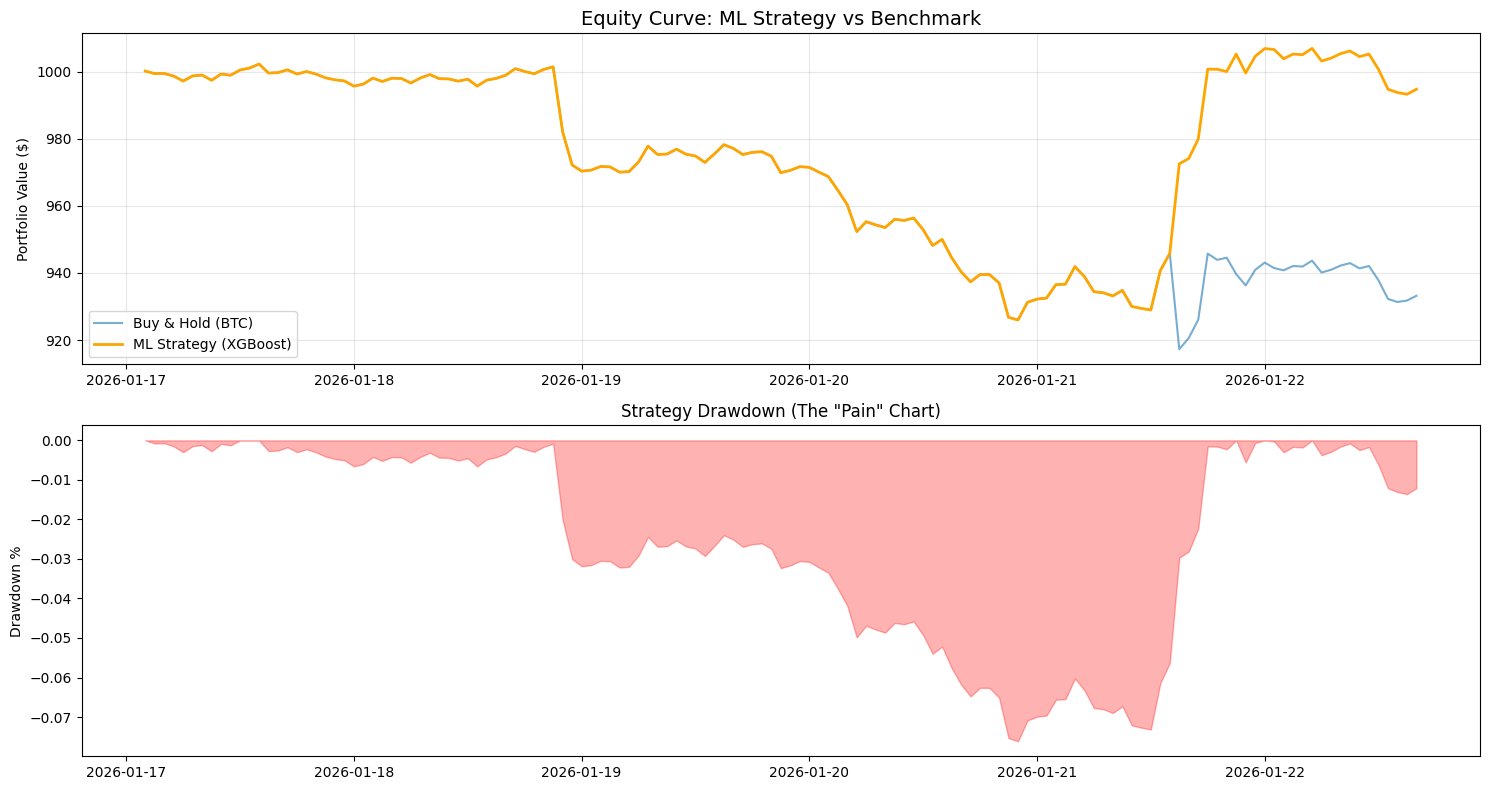

In [ ]:
plt.figure(figsize=(15, 8))

# Plot 1: Equity Curve
plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['cum_bh'], label='Buy & Hold (BTC)', alpha=0.6)
plt.plot(df['timestamp'], df['cum_strategy'], label='ML Strategy (XGBoost)', color='orange', linewidth=2)
plt.title('Equity Curve: ML Strategy vs Benchmark', fontsize=14)
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Drawdown
plt.subplot(2, 1, 2)
cum_wealth = (1 + df['net_return']).cumprod()
drawdown = (cum_wealth - cum_wealth.cummax()) / cum_wealth.cummax()
plt.fill_between(df['timestamp'], drawdown, 0, color='red', alpha=0.3)
plt.title('Strategy Drawdown (The "Pain" Chart)', fontsize=12)
plt.ylabel('Drawdown %')

plt.tight_layout()
plt.show()

- **Fees are the Enemy:** If your strategy makes money without fees but loses with fees, you must increase the threshold or add better Alpha factors.
- **Volatility Dampening:** An ideal ML strategy might not make more than BTC, but it should have a lower Drawdown. If BTC crashes 50% but your strategy only drops 10%, you have a winner.
- **Alpha Decay:** If the strategy performs well at the start of the test but poorly at the end, the model needs retraining (it is "decaying").

## Exporting for Flask App:
We save a small summary of our metrics and the last 100 predictions to be displayed in our UI.

In [ ]:
summary = {
    'final_balance': df['cum_strategy'].iloc[-1],
    'sharpe': s_sharpe,
    'max_drawdown': s_max_dd,
    'total_trades': df['trades'].sum()
}

# Save summary as a small dataframe
pd.DataFrame([summary]).to_csv(f"{project_path}/strategy_summary.csv", index=False)

# Save the final DF for the UI
df.tail(100).to_csv(f"{project_path}/ui_data_sample.csv", index=False)

print("Backtest results saved for Step 5.")

Backtest results saved for Step 5.
